In [30]:
import os
import math
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import seaborn as sns
from tqdm.notebook import tqdm

%matplotlib inline

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from tqdm import tqdm

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

#### Simple classifier


We will use a minimal network with a input layer, one hidden layer with tanh as activation function, and a output layer.  
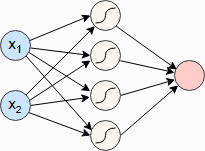

In [6]:
class SimpleClassifier(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

In [7]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# Printing a module shows all its submodules
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


In [8]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter linear1.weight, shape torch.Size([4, 2])
Parameter linear1.bias, shape torch.Size([4])
Parameter linear2.weight, shape torch.Size([1, 4])
Parameter linear2.bias, shape torch.Size([1])


#### The Dataset

In [12]:
class XORDataset(data.Dataset):
    """To define a dataset in PyTorch, we simply specify two functions: __getitem__, and __len__"""

    def __init__(self, size, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)

        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, index):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple

        data_point = self.data[index]
        data_label = self.label[index]
        return data_point, data_label

In [13]:
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([0.8314, 0.0705]), tensor(1))


VIsualization

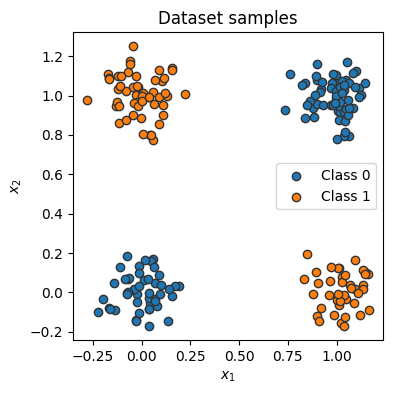

In [14]:
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4, 4))
    plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()
    
visualize_samples(dataset.data, dataset.label)
plt.show()

#### The class `torch.utils.data.DataLoader` 
It represents a Python iterable over a dataset with support for automatic batching, multi-process data loading and many more features. The data loader communicates with the dataset using the function __getitem__, and stacks its outputs as tensors over the first dimension to form a batch. In contrast to the dataset class, we usually don’t have to define our own data loader class, but can just create an object of it with the dataset as input. 

In [15]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)

# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

In [16]:
# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs torch.Size([8, 2]) 
 tensor([[ 1.0085,  1.0643],
        [ 0.1930,  0.0347],
        [ 0.0413, -0.0545],
        [ 1.0262,  1.0111],
        [ 0.2248,  1.0093],
        [-0.0190,  1.0442],
        [ 0.8854,  0.8907],
        [ 0.0683, -0.0435]])
Data labels torch.Size([8]) 
 tensor([0, 0, 0, 0, 1, 1, 0, 0])


#### Optimization
After defining the model and the dataset, it is time to prepare the optimization of the model. During training, we will perform the following steps:

1. Get a batch from the data loader
2. Obtain the predictions from the model for the batch
3. Calculate the loss based on the difference between predictions and labels
4. Backpropagation: calculate the gradients for every parameter with respect to the loss
5. Update the parameters of the model in the direction of the gradients

For BCE, PyTorch has two modules: nn.BCELoss(), nn.BCEWithLogitsLoss(). While nn.BCELoss expects the inputs 
 to be in the range 
, i.e. the output of a sigmoid, nn.BCEWithLogitsLoss combines a sigmoid layer and the BCE loss in a single class. This version is numerically more stable than using a plain Sigmoid followed by a BCE loss because of the logarithms applied in the loss function. 

Stochastic Gradient Descent updates parameters by multiplying the gradients with a small constant, called learning rate, and subtracting those from the parameters (hence minimizing the loss). Therefore, we slowly move towards the direction of minimizing the loss. A good default value of the learning rate for a small network as ours is 0.1.

In [17]:
loss_module = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

#### Training

In [18]:
train_dataset = XORDataset(size=2500)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)


def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    model.train()

    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:
            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)  # Output is [Batch size, 1], but we want [Batch size]

            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())

            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()

In [19]:
train_model(model, optimizer, train_data_loader, loss_module)

100%|██████████| 100/100 [00:03<00:00, 26.75it/s]


##### Saving model

In [20]:
state_dict = model.state_dict()
print(state_dict)

OrderedDict([('linear1.weight', tensor([[-3.3689,  2.6994],
        [-1.6417, -1.6961],
        [ 2.7515, -3.3417],
        [-0.0579, -0.2345]])), ('linear1.bias', tensor([-1.1486,  0.0428, -1.2078, -0.3557])), ('linear2.weight', tensor([[ 4.5434, -2.6014,  4.5613, -0.4153]])), ('linear2.bias', tensor([1.9093]))])


In [21]:
# torch.save(object, filename). For the filename, any extension can be used
torch.save(state_dict, "our_model.tar")

#### Loading model

In [24]:
# Load state dict from the disk (make sure it is the same name as above)
state_dict = torch.load("our_model.tar")

# Create a new model and load the state
new_model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
new_model.load_state_dict(state_dict)

# Verify that the parameters are the same
print("Original model\n", model.state_dict())
print("\nLoaded model\n", new_model.state_dict())

Original model
 OrderedDict([('linear1.weight', tensor([[-3.3689,  2.6994],
        [-1.6417, -1.6961],
        [ 2.7515, -3.3417],
        [-0.0579, -0.2345]])), ('linear1.bias', tensor([-1.1486,  0.0428, -1.2078, -0.3557])), ('linear2.weight', tensor([[ 4.5434, -2.6014,  4.5613, -0.4153]])), ('linear2.bias', tensor([1.9093]))])

Loaded model
 OrderedDict([('linear1.weight', tensor([[-3.3689,  2.6994],
        [-1.6417, -1.6961],
        [ 2.7515, -3.3417],
        [-0.0579, -0.2345]])), ('linear1.bias', tensor([-1.1486,  0.0428, -1.2078, -0.3557])), ('linear2.weight', tensor([[ 4.5434, -2.6014,  4.5613, -0.4153]])), ('linear2.bias', tensor([1.9093]))])


C:\Users\omkar\AppData\Local\Temp\ipykernel_27632\1838763438.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("our_model.tar")


#### Evaluation

In [25]:
test_dataset = XORDataset(size=500)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

 In PyTorch, we can deactivate the computation graph using with torch.no_grad(): .... Remember to additionally set the model to eval mode.

In [26]:
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [27]:
eval_model(model, test_data_loader)

Accuracy of the model: 100.00%


#### Visualizing classification boundaries

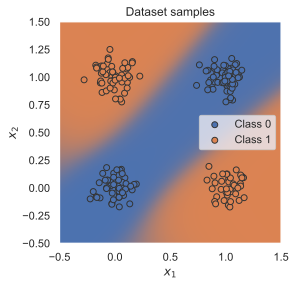

In [31]:
@torch.no_grad() # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy()  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(model, dataset.data, dataset.label)
plt.show()